In [3]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import fftpack
from scipy import integrate
from scipy import signal
%config InlineBackend.figure_format = 'svg'
#%matplotlib notebook

In [95]:
tem = 1
#L = 80
#k = 5*2*np.pi / L
k = 0.08
L = 5*2*np.pi/k
vmax = 20  # 10 * np.sqrt(tem)
nx = 201
nv = 401
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.01
max_steps  = 20000
data_steps = 100
data_num = int(max_steps/data_steps)
d = 0.01
kappa = 0

path = './data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt(tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]

print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("t_Bi = ", abs(1/np.sqrt(q*d)))

print("t_L = ", abs(1/s.x[1]))
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

data_num =  200
k =  0.08
w_r =  1.0096793428564657
w_i =  -1.067333781408555e-13
v_p =  12.62099178570582
t_Bi =  10.0
t_L =  9369140351580.6
limited time= 785.3981633974482
real time =  200.0


$$ \gamma = - \sqrt{\pi} \frac{\Gamma(\kappa_0+5/2)}{\Gamma(\kappa_0+1)} \kappa_0^{\kappa_0+1} \omega_r ( \frac{k^2 T}{m \omega^2_r} )^{\kappa_0+1}$$

In [96]:
w_r = np.sqrt( w_pe**2 + 3*k**2*tem**2/m )
#w_i = -np.sqrt(np.pi) * sp.gamma(kappa+5/2) / sp.gamma(kappa+1) * kappa**(kappa+1) * w_r * (k**2*tem/m/w_r**2)**(kappa+1)
w_i = -np.sqrt(np.pi) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5) * (2*kappa-3)**(kappa-0.5) * w_r * (k**2*tem/m/w_r**2)**(kappa-0.5)
print(w_r)
print(w_i)
print(-1/w_i)

1.009554357129917
(2.2519547568925525e-16-3.6777212147379164j)
(-1.6649532790029933e-17-0.27190750511285355j)


In [97]:
def fk(v, t, kappa):
    r = 0
    if(kappa == 0):
        r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r

In [98]:
progesses = np.arange(0,data_num,1)

f = []
E = []
T_x0 = []
n_x0 = []
E_x0 = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    E_temp = np.loadtxt(os.path.join(path,"E"+str(progess)))
    E.append(E_temp)
    E_x0.append(E_temp[0])
    f_temp_x0 = f_temp[0,:]
    fx_temp_x0 = np.sum(f_temp_x0)*dv
    T_temp_x0 = np.sum(v**2*f_temp_x0)*dv/fx_temp_x0
    T_x0.append(T_temp_x0)
    n_x0.append(fx_temp_x0)

In [99]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

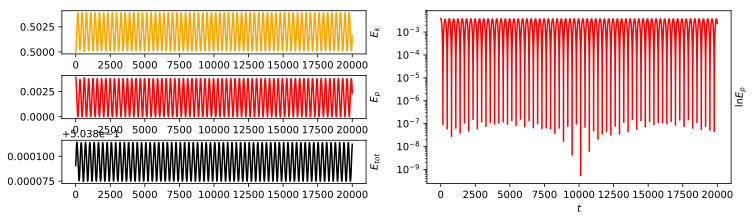

In [100]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

### 分布函数fx fv

In [101]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx

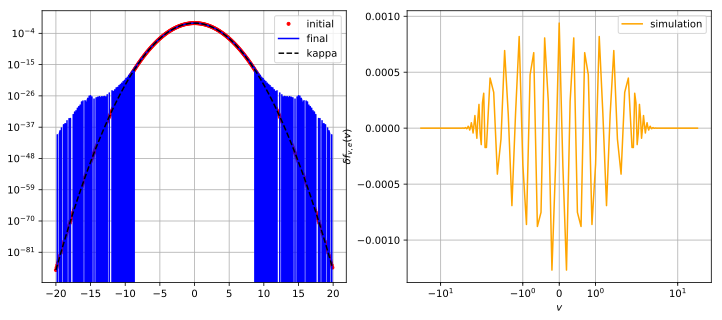

In [102]:
vstart = -vmax
vend = vmax
nvs = int((vstart + vmax ) / dv)
nve = int((vend + vmax) /dv)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v[nvs:nve],fv0[nvs:nve],'.',color='r',label='initial')
ax1.plot(v[nvs:nve],fv[nvs:nve],color='blue',label='final')
ax1.plot(v[nvs:nve],fk(v[nvs:nve],tem,kappa),'--',color='black',label='kappa')
ax1.set_yscale('log')

ax2.plot(v, fv-fv0, color='orange', label='simulation')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\delta f_{v,e}(v)$')
ax2.set_xscale('symlog')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 密度&温度分布

$$ \frac{n(x)}{n_0}=\left[ \frac{T(x)}{T_0} \right]^{-\kappa_0-1}$$
$$ \nabla \ln T = - \frac{1}{\kappa_0+1} \nabla \ln n$$

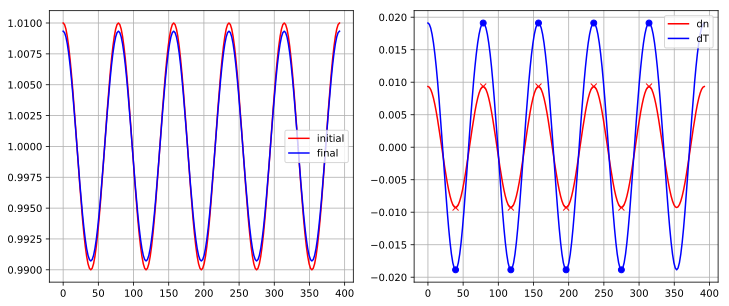

In [103]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(x,fx0,color='r',label='initial')
ax1.plot(x,fx,color='blue',label='final')

dn = fx - 1
dT = T - 1
dn_maxidx, _ = signal.find_peaks(dn, distance=5)
dn_minidx, _ = signal.find_peaks(-dn, distance=5)
dT_maxidx, _ = signal.find_peaks(dT, distance=5)
dT_minidx, _ = signal.find_peaks(-dT, distance=5)

ax2.plot(x,dn,color='r',label='dn')
ax2.plot(x[dn_maxidx[0:4]],dn[dn_maxidx[0:4]],'x',color='r')
ax2.plot(x[dn_minidx[0:4]],dn[dn_minidx[0:4]],'x',color='r')

ax2.plot(x,dT,color='blue',label='dT')
ax2.plot(x[dT_maxidx[0:4]],dT[dT_maxidx[0:4]],'o',color='blue')
ax2.plot(x[dT_minidx[0:4]],dT[dT_minidx[0:4]],'o',color='blue')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

In [104]:
dn_A = np.mean(dn[dn_maxidx[0:4]]-dn[dn_minidx[0:4]])
dT_A = np.mean(dT[dT_maxidx[0:4]]-dT[dT_minidx[0:4]])
print(dT_A/dn_A)

2.038775416510202


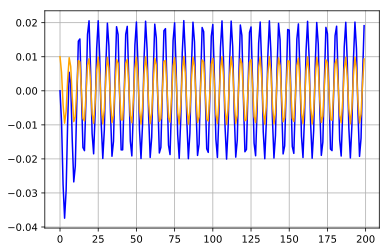

In [105]:
dn_x0 = np.array(n_x0) - 1
dT_x0 = np.array(T_x0) - tem
plt.plot(progesses,dT_x0,color='blue')
plt.plot(progesses,dn_x0,color='orange')
plt.grid()
plt.show()

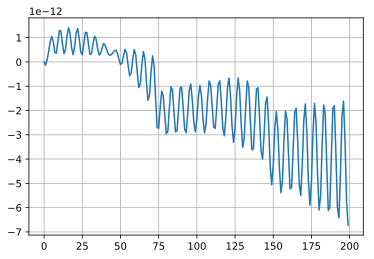

In [106]:
plt.plot(progesses,E_x0)
plt.grid()
plt.show()

In [69]:
kidx = np.array([1,2,3,5,10]) 
rate = np.array([2.828703,2.49596,2.153508,2.10872,2.081024])

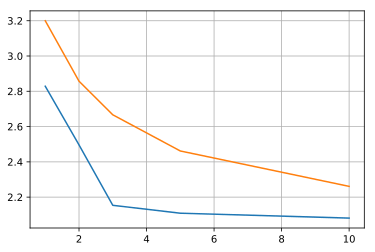

In [109]:
plt.plot(kidx,rate)
plt.plot(kidx,3*(kidx+2.5)/(kidx+1.5)-1)
plt.grid()
plt.show()